## Wordle Strategy Tool

### Prepare Environment

Load necessary packages and set `datapath` location

In [1]:
import numpy as np
import pandas as pd

Set `GOOGLE_DRIVE = True` and adjust the datapath reference below to use Google Drive to access the data files

In [2]:
GOOGLE_DRIVE = True

In [3]:
if GOOGLE_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive/')
  datapath = '/content/drive/My Drive/Colab Notebooks/UIUC/CS_410/Wordle/data/'
else:
  datapath = 'data/'

Mounted at /content/drive/


### Matrix Operations Tool

Create a method to encode a 5-letter word as a 5x26 matrix and use matrix
operations to efficiently validate guesses and conduct pattern matching with the vocabulary.

#### Word Encoding

In [4]:
abc = 'abcdefghijklmnopqrstuvwxyz'
', '.join([str(ord(c)) for c in abc])

'97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122'

Observe that we can numerically encode each letter in the alphabet using its unicode value.  We will subtract 97 to index starting at 0.

The function `encode_word` takes a word and encodes it into a 5x26 binary matrix, where each row of the matrix represents the character position in the word and each column of the matrix represents a letter of the alphabet. 

In [5]:
def encode_word(word):
  idx = [i*26 + ord(c) - 97 for i, c in enumerate(word)]
  w = np.zeros(5*26, dtype=int)
  w[idx] = 1
  w = w.reshape((5, 26))
  return(w)

Word encoding examples:

In [6]:
taxes = encode_word('taxes')
texas = encode_word('texas')
crate = encode_word('crate')
crane = encode_word('crane')

words = np.array([taxes, texas, crate, crane])

In [7]:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))

In [8]:
taxes

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

Observe that matrix entry row 2, column 1 is equal to 1, which corresponds to the letter 'a' in the word 'taxes'.  

Note that 'a' is the 2nd letter of 'taxes' (matrix row 2) and the 1st letter of the alphabet (matrix column 1).

#### Guess Evaluation

In [9]:
crane @ crate.T

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])

Observe that the diagonal entries indicate the position of correct, i.e. Wordle green, letter placements

In [10]:
taxes @ texas.T

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1]])

Observe that the off-diagonal entries indicate the position of misplaced, i.e. Wordle yellow, letters

Let's use these observations to create an alogorithm for Wordle guess evaluation:

In [11]:
mm = taxes @ texas.T

In [12]:
idx_green = np.diag(mm)
idx_green

array([1, 0, 1, 0, 1])

For misplaced letters, let's return -1:

In [13]:
idx_yellow = np.diag(mm) - mm.max(axis = 0) 
idx_yellow

array([ 0, -1,  0, -1,  0])

Let's pull this together to return a single evaluation result.

- 1 = correct letter
- -1 = misplaced letter
- 0 = incorrect letter

In [14]:
2*np.diag(mm) - mm.max(axis = 0) 

array([ 1, -1,  1, -1,  1])

The function `eval_guess` takes a `guess` word and uses matrix operations to return the letter placement results versus the `secret` word.

In [15]:
def eval_guess(guess, secret):
  encoded_guess = encode_word(guess)
  encoded_secret = encode_word(secret)
  mm = encoded_secret @ encoded_guess.T 
  result = 2*np.diag(mm) - mm.max(axis = 0)
  return result

In [16]:
eval_guess('crate', 'crane')

array([1, 1, 1, 0, 1])

In [17]:
eval_guess('taxes', 'texas')

array([ 1, -1,  1, -1,  1])

### Prepare Words

Load and encode the Wordle words:

In [18]:
all_words = []
encoded_all = []

with open(datapath + "allowed_words.txt", "r") as fin:
  for line in fin:
    word = line.strip()
    all_words.append(word)
    encoded_all.append(encode_word(word))

all_words = np.array(all_words)
encoded_all = np.array(encoded_all)

In [19]:
len(all_words)

12972

In [20]:
possible_words = []
encoded_possible = []

with open(datapath + "possible_words.txt", "r") as fin:
  for line in fin:
    word = line.strip()
    possible_words.append(word)
    encoded_possible.append(encode_word(word))

possible_words = np.array(possible_words)
encoded_possible = np.array(encoded_possible)

In [21]:
len(possible_words)

2315

Load the POS tagging likelihood dataframe:

In [22]:
all_pos = pd.read_csv(datapath + 'all_pos.csv')
all_pos.set_index('word', inplace=True)
all_pos.head()

,tag,p
word,,
aahed,VBN,0.013752
aalii,JJ,0.218075
aargh,NN,0.618861
aarti,NN,0.618861
abaca,NN,0.618861


Load the TF_IDF likelihood dataframe:

In [23]:
all_tf = pd.read_csv(datapath + 'all_tf.csv')
all_tf.set_index('word', inplace=True)
all_tf.head()

,p
word,
aahed,4.629283e-08
aalii,3.594560e-10
aargh,4.751212e-09
aarti,1.331110e-08
abaca,2.638774e-08


Merge the POS and TF-IDF likelihood dataframes:

In [24]:
all_freq = all_pos.merge(all_tf, on='word', suffixes=('_pos', '_tf'))
all_freq['p'] = all_freq['p_pos']*all_freq['p_tf']

Load the past Wordle solution words for strategy evaluation:

In [25]:
with open(datapath + "past_words.txt", "r") as fin:
  past_words = [line.strip() for line in fin]

n_games = len(past_words)
n_games

509

### Game Strategy

Function `batch_eval` evaluates a `guess` word against all possible words in `encoded_words` and returns the eval pattern for each possible word.  This is useful for finding words that have the same pattern as the solution word.

In [26]:
def batch_eval(guess, encoded_words):
  encoded_guess = encode_word(guess)
  mm = np.inner(encoded_words, encoded_guess)
  patterns = 2*np.diagonal(mm, axis1=1, axis2=2) - mm.max(axis=1)
  return patterns

Function `correct_guess` returns `True` if the eval pattern is [1, 1, 1, 1, 1].

In [27]:
def correct_guess(pattern):
  return pattern.sum() == len(pattern)

Function `pattern_match` returns the index for all `patterns` equal to `pattern`.  This is useful for reducing the solution space after a guess.

In [28]:
def pattern_match(pattern, patterns):
  return np.where((patterns == pattern).all(axis=1))

Function `discrete_probability` returns the discrete probability distribution for a vector of `counts`.

In [33]:
def discrete_probability(counts):
  return counts/counts.sum()

Function `entropy` returns the entropy for a given probability.

In [34]:
def entropy(p):
  return p*np.log2(p) - (1 - p)*np.log2(1 - p)  

Function `pos_probability` returns the POS tag probability for a given `word` and function `tf_probability` returns the TF-IDF likelihood for a given `word`.

In [35]:
def pos_probability(word):
  return all_pos.loc[word]['p']

def tf_probability(word):
  return all_tf.loc[word]['p']

Function `get_possible_words` returns the solution space of words in text and encoded format given a current `guess` and guess evaluation `pattern.

In [29]:
def get_possible_solutions(guess, pattern, words, encoded_words):
  patterns = batch_eval(guess, encoded_words)
  idx_pattern = pattern_match(pattern, patterns)
  return words[idx_pattern], encoded_words[idx_pattern]

In [60]:
sol_words, encoded_sols = get_possible_solutions('salet', eval_guess('salet', 'abyss'), possible_words, encoded_possible)
sol_words

array(['abyss', 'amass', 'amiss', 'arson', 'assay', 'awash', 'brash', 'brass', 'chaos', 'chasm', 'crash', 'crass', 'gnash', 'grasp', 'grass', 'quash', 'quasi'], dtype='<U5')

Function `get_next_guess` returns the optimal guess word using entropy given the available remaining `words`.

In [31]:
def get_next_guess(words, encoded_words):
  # score the potential solutions by entropy variance
  best_score = 0
  best_i = 0
  # iterate through remaining words
  for i in range(len(words)):
    patterns = batch_eval(words[i], encoded_words)      
    unique_patterns, unique_counts = np.unique(patterns, return_counts=True, axis=0)
    p = discrete_probability(unique_counts)
    if len(p) == 1:
      best_i = i
      break
    h = entropy(p)
    # favor results with uniform distributions
    score = len(h)/(h.var() + 1)
    if score > best_score:
      best_score = score
      best_i = i
    
  return best_i, words[best_i]

In [61]:
idx, guess = get_next_guess(sol_words, encoded_sols)
guess

'brash'

Function `play_game_entropy` will run through a complete Wordle game and return the `guesses` used to find the solution.  It favors guesses that yield uniform pattern distributions with high entropy.

In [44]:
def play_game_entropy(guess, secret, words, encoded_words):
  guesses = []
  n_guesses = 0    
  
  while len(words) > 0:
    pattern = eval_guess(guess, secret)    
    
    if correct_guess(pattern):  
      break
 
    guesses.append(guess)
    n_guesses += 1

    words, encoded_words = get_possible_solutions(guess, pattern, words, encoded_words)
    
    idx, guess = get_next_guess(words, encoded_words)
    
    # remove guess from potential solutions in next iteration
    encoded_words = np.delete(encoded_words, idx, axis=0)
    words = np.delete(words, idx, axis=0)    

  guesses.append(guess)
  n_guesses += 1
  return guesses

Function `play_game_frequency` will run through a complete Wordle game and return the `guesses` used to find the solution.  It selects a guess based on which possible word has the highest combined TF-IDF and POS likelihood.

In [40]:
def play_game_frequency(guess, secret, words, encoded_words, freq_df):
  guesses = []
  n_guesses = 0    
  
  while len(words) > 0:
    pattern = eval_guess(guess, secret)    
    
    if correct_guess(pattern):  
      break
 
    guesses.append(guess)
    n_guesses += 1

    words, encoded_words = get_possible_solutions(guess, pattern, words, encoded_words)

    # of possible words, use one with highest tf*pos probability
    idx = freq_df.loc[words]['p'].argmax()    
    guess = words[idx]    
    
    # remove guess from potential solutions in next iteration    
    encoded_words = np.delete(encoded_words, idx, axis=0)
    words = np.delete(words, idx, axis=0)    

  guesses.append(guess)
  n_guesses += 1
  return guesses

### Evaluation

#### Guess using Entropy

In [ ]:
openers = np.random.choice(possible_words, n_games, replace=True)

Play all previous Wordle games using a random word for the opening guess:

In [46]:
game_scores = np.zeros(n_games, dtype=int)

for i, secret in enumerate(past_words):  

  guess = openers[i]
  guesses = play_game_entropy(guess, secret, possible_words, encoded_possible)  
  game_scores[i] = len(guesses)
  print(i, guesses, game_scores[i])

print('Mean Score:', game_scores[game_scores < 7].mean())
print('Games Won in 2 Guesses:', sum(game_scores < 3))
print('Games Lost:', sum(game_scores > 6))

random_entropy_scores = game_scores.copy()

0 ['prank', 'later', 'augur', 'cigar'] 4
1 ['clove', 'tread', 'beret', 'rebut'] 4
2 ['arson', 'pushy', 'missy', 'sissy'] 4
3 ['grade', 'hoist', 'humph'] 3
4 ['nobly', 'crate', 'shade', 'awake'] 4
5 ['pushy', 'brush', 'blush'] 3
6 ['wince', 'coral', 'focal'] 3
7 ['juror', 'slate', 'heave', 'evade'] 4
8 ['cadet', 'salon', 'lanky', 'naval'] 4
9 ['badly', 'trice', 'surge', 'serve'] 4
10 ['mafia', 'slate', 'death', 'heath'] 4
11 ['vapor', 'trace', 'award', 'dwarf'] 4
12 ['detox', 'horde', 'model'] 3
13 ['snail', 'cater', 'harpy', 'karma'] 4
14 ['spoke', 'slunk', 'shank', 'stink'] 4
15 ['steed', 'drone', 'pride', 'crude', 'grade'] 5
16 ['salve', 'diner', 'chief', 'quiet'] 4
17 ['tidal', 'curse', 'beech', 'bench'] 4
18 ['ramen', 'slate', 'abate'] 3
19 ['pedal', 'resin', 'feign'] 3
20 ['hater', 'valor', 'major'] 3
21 ['twang', 'least', 'death'] 3
22 ['mount', 'parse', 'cress', 'fresh'] 4
23 ['infer', 'court', 'crust'] 3
24 ['inlay', 'slept', 'stool'] 3
25 ['logic', 'color', 'colon'] 3
26 ['cha

In [47]:
%timeit play_game_entropy('smell', 'mummy', possible_words, encoded_possible)

58.2 ms ± 23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The word 'salet' is a popular opening guess among Wordle enthusiasts.  Let's see how 'salet' performs versus a random opening guess:

In [52]:
game_scores = np.zeros(n_games, dtype=int)

for i, secret in enumerate(past_words):  

  guess = 'salet'
  guesses = play_game_entropy(guess, secret, possible_words, encoded_possible)  
  game_scores[i] = len(guesses)
  print(i, guesses, game_scores[i])

print('Mean Score:', game_scores[game_scores < 7].mean())
print('Games Won in 2 Guesses:', sum(game_scores < 3))
print('Games Lost:', sum(game_scores > 6))

salet_entropy_scores = game_scores.copy()

0 ['salet', 'adorn', 'chair', 'cigar'] 4
1 ['salet', 'erect', 'merit', 'rebut'] 4
2 ['salet', 'spiny', 'sissy'] 3
3 ['salet', 'round', 'guppy', 'humph'] 4
4 ['salet', 'beard', 'awake'] 3
5 ['salet', 'floss', 'blush'] 3
6 ['salet', 'final', 'focal'] 3
7 ['salet', 'beard', 'adage', 'evade'] 4
8 ['salet', 'banal', 'naval'] 3
9 ['salet', 'spire', 'serve'] 3
10 ['salet', 'grate', 'death', 'heath'] 4
11 ['salet', 'adorn', 'chard', 'diary', 'dwarf'] 5
12 ['salet', 'liver', 'bowel', 'model'] 4
13 ['salet', 'cairn', 'harpy', 'karma'] 4
14 ['salet', 'story', 'stink'] 3
15 ['salet', 'beard', 'drake', 'grade'] 4
16 ['salet', 'beret', 'comet', 'duvet', 'quiet'] 5
17 ['salet', 'drone', 'begin', 'bench'] 4
18 ['salet', 'grate', 'abate'] 3
19 ['salet', 'drone', 'begin', 'feign'] 4
20 ['salet', 'cairn', 'harpy', 'favor', 'major'] 5
21 ['salet', 'grate', 'death'] 3
22 ['salet', 'purse', 'cress', 'fresh'] 4
23 ['salet', 'worst', 'crust'] 3
24 ['salet', 'sloth', 'stool'] 3
25 ['salet', 'moldy', 'colon'] 3

In [53]:
%timeit play_game_entropy('salet', 'mummy', possible_words, encoded_possible)

204 ms ± 52.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Guess using TF-IDF and POS Likelihood

Play all previous Wordle games using a random word for the opening guess:

In [54]:
game_scores = np.zeros(n_games, dtype=int)

for i, secret in enumerate(past_words):  

  guess = openers[i]
  guesses = play_game_frequency(guess, secret, possible_words, encoded_possible, all_freq)   
  game_scores[i] = len(guesses)
  print(i, guesses, game_scores[i])

print('Mean Score:', game_scores[game_scores < 7].mean())
print('Games Won in 2 Guesses:', sum(game_scores < 3))
print('Games Lost:', sum(game_scores > 6))

random_frequency_scores = game_scores.copy()

0 ['prank', 'water', 'sugar', 'cigar'] 4
1 ['clove', 'water', 'trend', 'merit', 'rebut'] 5
2 ['arson', 'issue', 'visit', 'wispy', 'missy', 'sissy'] 6
3 ['grade', 'think', 'couch', 'humph'] 4
4 ['nobly', 'state', 'image', 'peace', 'aware', 'awake'] 6
5 ['pushy', 'house', 'brush', 'blush'] 4
6 ['wince', 'class', 'local', 'focal'] 4
7 ['juror', 'think', 'place', 'adage', 'evade'] 5
8 ['cadet', 'basis', 'major', 'happy', 'naval'] 5
9 ['badly', 'think', 'power', 'curve', 'serve'] 5
10 ['mafia', 'place', 'heart', 'heath'] 4
11 ['vapor', 'heart', 'award', 'dwarf'] 4
12 ['detox', 'order', 'model'] 3
13 ['snail', 'water', 'marry', 'karma'] 4
14 ['spoke', 'skill', 'stick', 'stink'] 4
15 ['steed', 'drive', 'grade'] 3
16 ['salve', 'other', 'quiet'] 3
17 ['tidal', 'power', 'sense', 'bench'] 4
18 ['ramen', 'place', 'state', 'abate'] 4
19 ['pedal', 'sense', 'begin', 'reign', 'feign'] 5
20 ['hater', 'labor', 'major'] 3
21 ['twang', 'state', 'death'] 3
22 ['mount', 'place', 'river', 'fresh'] 4
23 ['inf

In [56]:
%timeit play_game_frequency('smell', 'mummy', possible_words, encoded_possible, all_freq)

5.93 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The word 'salet' is a popular opening guess among Wordle enthusiasts.  Let's see how 'salet' performs versus a random opening guess:

In [57]:
game_scores = np.zeros(n_games, dtype=int)

for i, secret in enumerate(past_words):  

  guess = 'salet'
  guesses = play_game_frequency(guess, secret, possible_words, encoded_possible, all_freq)  
  game_scores[i] = len(guesses)
  print(i, guesses, game_scores[i])

print('Mean Score:', game_scores[game_scores < 7].mean())
print('Games Won in 2 Guesses:', sum(game_scores < 3))
print('Games Lost:', sum(game_scores > 6))

salet_frequency_scores = game_scores.copy()

0 ['salet', 'woman', 'cigar'] 3
1 ['salet', 'event', 'merit', 'rebut'] 4
2 ['salet', 'shook', 'swung', 'sissy'] 4
3 ['salet', 'group', 'punch', 'humph'] 4
4 ['salet', 'heard', 'image', 'quake', 'awake'] 5
5 ['salet', 'locus', 'blush'] 3
6 ['salet', 'claim', 'local', 'focal'] 4
7 ['salet', 'heard', 'adage', 'evade'] 4
8 ['salet', 'labor', 'daily', 'naval'] 4
9 ['salet', 'sense', 'serve'] 3
10 ['salet', 'death', 'heath'] 3
11 ['salet', 'woman', 'award', 'dwarf'] 4
12 ['salet', 'level', 'model'] 3
13 ['salet', 'major', 'karma'] 3
14 ['salet', 'study', 'stock', 'stink'] 4
15 ['salet', 'heard', 'grade'] 3
16 ['salet', 'quiet'] 2
17 ['salet', 'voice', 'mercy', 'bench'] 4
18 ['salet', 'death', 'crate', 'abate'] 4
19 ['salet', 'voice', 'being', 'reign', 'feign'] 5
20 ['salet', 'major'] 2
21 ['salet', 'death'] 2
22 ['salet', 'house', 'fresh'] 3
23 ['salet', 'first', 'trust', 'crust'] 4
24 ['salet', 'still', 'stool'] 3
25 ['salet', 'color', 'colon'] 3
26 ['salet', 'phase', 'cease', 'erase', 'aba

In [58]:
%timeit play_game_frequency('salet', 'mummy', possible_words, encoded_possible, all_freq)

7.46 ms ± 88.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Using TF-IDF POS likelihood approach has a ~20x speedup compared to the entropy approach.

### Results

In [59]:
results_df = pd.DataFrame({'random_entropy':pd.Series(random_entropy_scores).describe(), 'random_frequency':pd.Series(random_frequency_scores).describe(),
                           'salet_entropy':pd.Series(salet_entropy_scores).describe(), 'salet_frequency':pd.Series(salet_frequency_scores).describe()})
results_df.loc[['mean', 'std']]

,random_entropy,random_frequency,salet_entropy,salet_frequency
mean,3.709234,4.056974,3.538310,3.768173
std,0.845282,1.039901,0.835368,1.033536


Using 'salet' as the opening guess combined with the entropy guessing approach yielded the best average Wordle game score of 3.53.  

The average score of 3.53 beats the average human score of 3.919, which was the performance target.

It's worth noting that the POS and TF-IDF likelihood guessing approach also achieved better results than the human player average, and did so at a ~20x speedup compared to the entropy approach.  The POS and TF-IDF likelihood guessing approach also had the most games won (48) in 2 guesses or less.



### Game Demo

Demonstrate this strategy tool using the official Wordle game (https://www.nytimes.com/games/wordle/index.html) using the word for the day on December 8, 2022.

We will relay the status from the game board to the strategy tool by typing 0 for gray letters, -1 for yellow letters, and 1 for green letters.

How to input pattern into `get_possible_solution`:

$$
\bigg[
\quad
\underline{ }\underline{ }\quad
\underline{ }\underline{ }\quad
\underline{ }\underline{ }\quad
\underline{ }\underline{ }\quad
\underline{ }\underline{ }\quad
\bigg]
\begin{cases}
1 & \text{correct (green)}\\
0 & \text{incorrect (gray)}\\
-1 & \text{misplaced (yellow)}\\
\end{cases}
$$

Opening guess:  SALET

In [62]:
sol_words, encoded_sols = get_possible_solutions('salet', [0, 0, 0, 1, 0], possible_words, encoded_possible)
sol_words

array(['bicep', 'boney', 'boxer', 'breed', 'brief', 'buyer', 'cheek', 'cheer', 'chief', 'cider', 'corer', 'coven', 'cover', 'covey', 'cower', 'creed', 'creek', 'creep', 'cried', 'crier', 'cyber', 'defer', 'dicey', 'diner', 'diver', 'dopey', 'dozen', 'dried', 'drier', 'dryer', 'embed', 'ember', 'emcee', 'fever', 'fewer', 'fiber', 'finer', 'fixer', 'foyer', 'freed', 'freer', 'fried', 'given', 'giver', 'goner', 'gooey', 'greed', 'green', 'grief', 'homer', 'honey', 'hover', 'hymen', 'hyper', 'index', 'infer', 'inner', 'joker', 'kneed', 'miner', 'modem', 'money', 'mover', 'mower', 'never', 'newer', 'nicer', 'odder', 'offer', 'order', 'owner', 'piney', 'piper', 'poker', 'power', 'preen', 'pried', 'puree', 'purer', 'queen', 'queer', 'refer', 'renew', 'rider', 'ripen', 'riper', 'river', 'rodeo', 'roger', 'rover', 'rower', 'ruder', 'rupee', 'udder', 'under', 'unfed', 'unwed', 'upper', 'video', 'viper', 'vixen', 'widen', 'wider', 'woken', 'women', 'wooer', 'woven'], dtype='<U5')

In [63]:
idx, guess = get_next_guess(sol_words, encoded_sols)
guess

'diner'

Next guess: DINER

In [64]:
sol_words, encoded_sols = get_possible_solutions('diner', [0, -1, -1, 1, 1], sol_words, encoded_sols)
sol_words

array(['infer'], dtype='<U5')

Next guess:  INFER

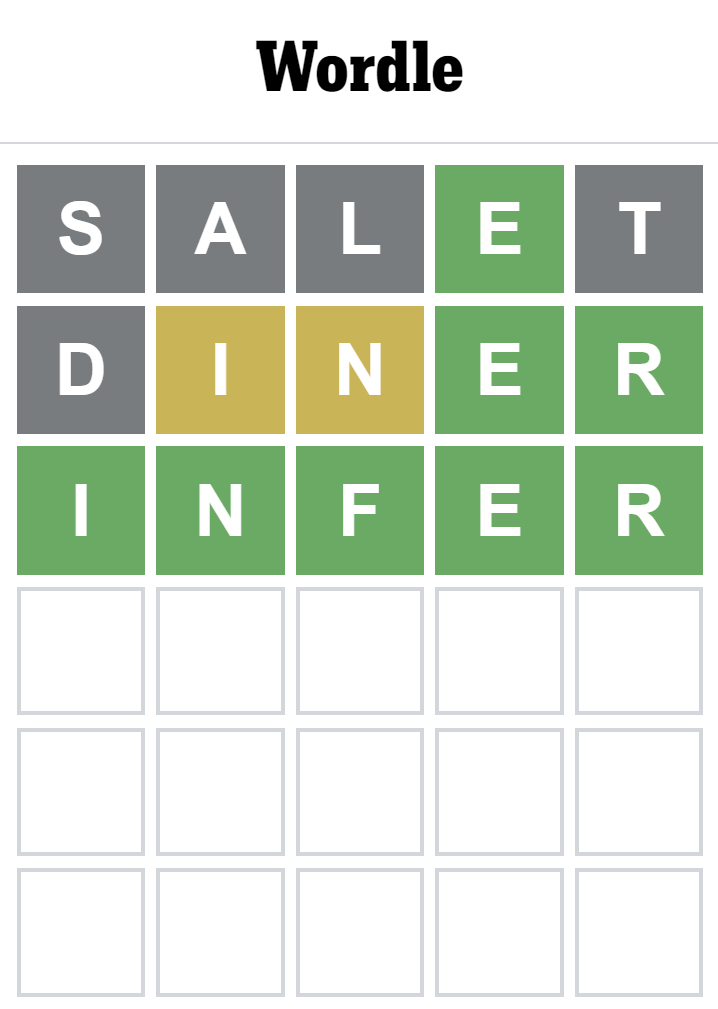

Correct! 